In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

# Imbalanced Learning (For Objective A)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Pipeline for Regression (Standard sklearn pipeline)
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


In [2]:
# Cell 2: Load Data
# Assuming the file is named 'loan_dataset.csv' or 'loan_dataset.xlsx'
try:
    df = pd.read_csv('loan_dataset.csv')
except:
    df = pd.read_excel('loan_dataset.xlsx')

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (20000, 33)


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,TotalLiabilities,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-06-18,37,36562,553,Employed,High School,14,38934,48,Married,...,9589,49.207,4,2603208,257.434,22.178,1230.4,6.605,1,42.4
1,2054-02-27,77,84454,676,Unemployed,Bachelor,55,9856,36,Divorced,...,20691,9.744,6,2598936,156.856,1.482,3408.1,14.462,1,30.4
2,2059-01-20,36,55540,614,Employed,High School,11,21670,12,Married,...,33311,8.786,3,2108279,17.967,21.558,2023.5,5.968,1,34.4
3,2042-09-07,28,88051,523,Employed,Associate,7,17982,36,Married,...,24934,8.834,1,2106873,241.482,27.021,734.3,20.842,1,33.6
4,2032-01-08,23,21775,581,Employed,Bachelor,3,67419,36,Married,...,34883,674.315,5,2088949,261.919,2.613,2721.1,1.820,0,44.0


In [3]:
# Cell 3: Basic Cleaning
# 1. Drop Duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Duplicates removed: {initial_rows - len(df)}")

# 2. Handle Missing Values (Simple Imputation for now)
# For numerical: fill with median. For categorical: fill with mode.
# In a real job, you'd investigate WHY they are missing first.
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

print("✅ Basic Cleaning Complete")

Duplicates removed: 0
✅ Basic Cleaning Complete


In [4]:
# Cell 4: Anomaly Detection
print("Running Isolation Forest to remove outliers...")

# Select numerical features for anomaly detection
features_for_anomaly = ['AnnualIncome', 'CreditScore', 'LoanAmount', 'TotalAssets']

# Initialize Isolation Forest (contamination=0.02 means we expect ~2% outliers)
iso = IsolationForest(contamination=0.02, random_state=42)
y_anomaly = iso.fit_predict(df[features_for_anomaly])

# Keep only normal points (where y_anomaly == 1)
# -1 indicates an outlier
df_clean = df[y_anomaly == 1].copy()

print(f"Original Rows: {len(df)}")
print(f"Cleaned Rows: {len(df_clean)}")
print(f"Outliers Removed: {len(df) - len(df_clean)}")

Running Isolation Forest to remove outliers...
Original Rows: 20000
Cleaned Rows: 19600
Outliers Removed: 400


In [5]:
# Cell 5: Feature Engineering
print("Creating Financial Ratios...")

# 1. Debt-to-Income Ratio (DTI)
# Note: Converting Annual Income to Monthly for accurate ratio
df_clean['DTI_Ratio'] = (df_clean['MonthlyDebtPayments'] + df_clean['MonthlyLoanPayment']) / (df_clean['AnnualIncome'] / 12)

# 2. Loan-to-Value Ratio (LTV)
# Avoid division by zero with .replace(0, 1)
df_clean['LTV_Ratio'] = df_clean['LoanAmount'] / df_clean['TotalAssets'].replace(0, 1)

# 3. Liquidity Ratio (Runway)
df_clean['Liquidity_Ratio'] = (df_clean['SavingsAccountBalance'] + df_clean['CheckingAccountBalance']) / df_clean['MonthlyLoanPayment']

# 4. Disposable Income
df_clean['Disposable_Income'] = (df_clean['AnnualIncome'] / 12) - (df_clean['MonthlyDebtPayments'] + df_clean['MonthlyLoanPayment'])

print("✅ New Features Created: DTI_Ratio, LTV_Ratio, Liquidity_Ratio, Disposable_Income")

Creating Financial Ratios...
✅ New Features Created: DTI_Ratio, LTV_Ratio, Liquidity_Ratio, Disposable_Income


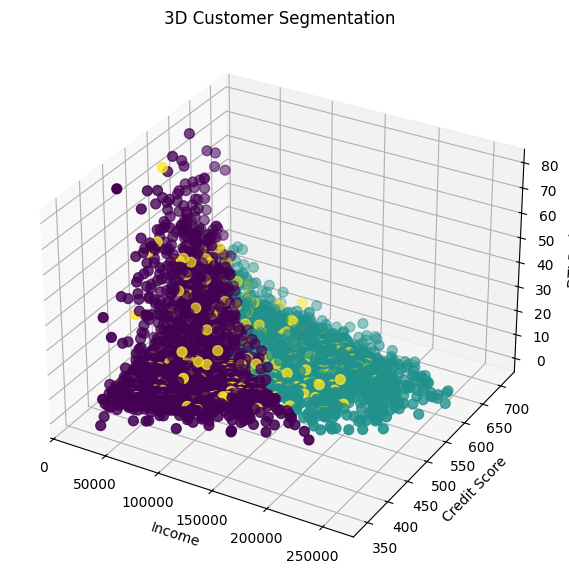

In [6]:
# Cell 6: Clustering
from sklearn.preprocessing import StandardScaler

# Select features for clustering
cluster_features = ['AnnualIncome', 'CreditScore', 'DTI_Ratio', 'TotalAssets']
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_clean[cluster_features])

# Run K-Means (3 Clusters for Low/Med/High profiles)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Customer_Segment'] = kmeans.fit_predict(X_cluster)

# Visualizing the Clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_clean['AnnualIncome'], df_clean['CreditScore'], df_clean['DTI_Ratio'],
                c=df_clean['Customer_Segment'], cmap='viridis', s=50)
ax.set_xlabel('Income')
ax.set_ylabel('Credit Score')
ax.set_zlabel('DTI Ratio')
plt.title("3D Customer Segmentation")
plt.show()